##**Intermittent demand forecasting**

**Importing Libraries for Data Processing**

In [67]:
import numpy as np
import pandas as pd

**Importing Libraries for Visualisation**

In [68]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [69]:
import plotly.io as pio

In [70]:
pip install plotly-templates


ERROR: Could not find a version that satisfies the requirement plotly-templates (from versions: none)
ERROR: No matching distribution found for plotly-templates


In [71]:
pio.templates.default = "plotly_dark"

**Importing Libraries for Modeling**

In [72]:
pip install skforecast


In [73]:
# Importing the LGBMRegressor from the LightGBM library for gradient boosting-based regression
from lightgbm import LGBMRegressor

# Importing the FunctionTransformer from sklearn.preprocessing for custom data transformation
from sklearn.preprocessing import FunctionTransformer

# Importing the mean_absolute_error function from sklearn.metrics for evaluating forecast accuracy
from sklearn.metrics import mean_absolute_error

# Importing the ForecasterAutoreg class from skforecast.ForecasterAutoreg for autoregressive time series forecasting
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Importing the ForecasterAutoregCustom class from skforecast.ForecasterAutoregCustom for custom autoregressive forecasting models
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom

# Importing the grid_search_forecaster function from skforecast.model_selection for hyperparameter tuning using grid search
from skforecast.model_selection import grid_search_forecaster

# Importing the backtesting_forecaster function from skforecast.model_selection for evaluating forecast performance through backtesting
from skforecast.model_selection import backtesting_forecaster


**About the Data**

The dataset used in this example represents the number of users visiting a store during its operating hours
The store operates from Monday to Friday
Predictions made outside of these operating days and hours are irrelevant and can either be ignored or set to 0


In [75]:
input = ('/content/intermittent_demand.csv')
data = pd.read_csv(input, sep=',')

In [76]:
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S') #formatting the date
data = data.set_index('date_time')
data = data.asfreq('H')

In [98]:
data = data.sort_index()
data.head()

,users,week_day,hour_day,is_closed
date_time,,,,
2011-01-01 00:00:00,0.0,6,1,True
2011-01-01 01:00:00,0.0,6,2,True
2011-01-01 02:00:00,0.0,6,3,True
2011-01-01 03:00:00,0.0,6,4,True
2011-01-01 04:00:00,0.0,6,5,True


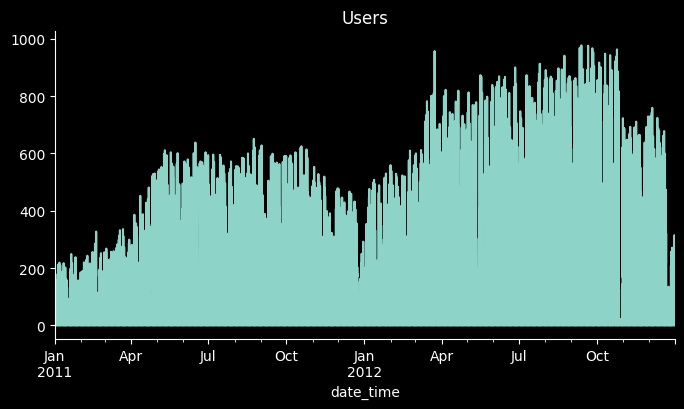

In [79]:
# Set the style to dark background
plt.style.use('dark_background')

# Plot the data
data['users'].plot(kind='line', figsize=(8, 4), title='Users')

# Remove top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Show the plot
plt.show()


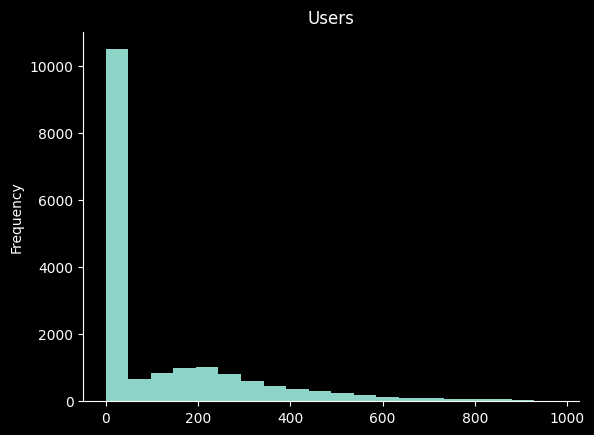

In [80]:
# Set the style to dark background
plt.style.use('dark_background')

# Plot the histogram
data['users'].plot(kind='hist', bins=20, title='Users')

# Remove top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Show the plot
plt.show()


Splitting the data in train-test-val

In [81]:
# Splitting the data into training, validation, and test sets based on specified end dates
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'

# Subsetting the data into respective sets
data_train = data.loc[:end_train]
data_val = data.loc[end_train:end_validation]
data_test = data.loc[end_validation:]

# Printing information about the split data
print(f"Training Period: {data_train.index.min()} - {data_train.index.max()}  (Samples: {len(data_train)})")
print(f"Validation Period: {data_val.index.min()} - {data_val.index.max()}  (Samples: {len(data_val)})")
print(f"Test Period: {data_test.index.min()} - {data_test.index.max()}  (Samples: {len(data_test)})")


Training Period: 2011-01-01 00:00:00 - 2012-03-31 23:00:00  (Samples: 10944)
Validation Period: 2012-04-01 00:00:00 - 2012-08-31 23:00:00  (Samples: 3672)
Test Period: 2012-09-01 00:00:00 - 2012-12-31 23:00:00  (Samples: 2928)


**Plot time series**

In [82]:
fig = go.Figure()

# Create traces for each dataset with different colors
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['users'], name="Train", mode="lines", line=dict(color='blue')))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['users'], name="Validation", mode="lines", line=dict(color='green')))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['users'], name="Test", mode="lines", line=dict(color='red')))

# Update layout of the figure
fig.update_layout(
    title="Time series of users",
    xaxis_title="Date time",
    yaxis_title="Users",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)

# Show the figure
fig.show()


Boxplot for weekly seasonality

In [83]:
data['week_day'] = data.index.day_of_week + 1

fig = px.box(
    data,
    x="week_day",
    y="users",
    title='Distribution of users per day of week',
    width=600,
    height=300
)

median_values = data.groupby('week_day')['users'].median()

# Change color of the box plot
fig.update_traces(marker_color='green', boxmean='sd')

# Add median line with a different color
fig.add_trace(
    go.Scatter(
        x=median_values.index,
        y=median_values.values,
        mode='lines+markers',
        line=dict(color='red', dash='dash'),
        showlegend=False
    )
)

fig.update_layout(margin=dict(l=20, r=20, t=35, b=20))

fig.show()


Boxplot for daily seasonality



In [84]:
data['hour_day'] = data.index.hour + 1

fig = px.box(
    data,
    x="hour_day",
    y="users",
    title='Distribution of users per hour of day',
    width=600,
    height=300
)

median_values = data.groupby('hour_day')['users'].median()

# Change color of the box plot
fig.update_traces(marker_color='orange', boxmean='sd')

# Add median line with a different color
fig.add_trace(
    go.Scatter(
        x=median_values.index,
        y=median_values.values,
        mode='lines+markers',
        line=dict(color='purple', dash='dash'),
        showlegend=False
    )
)

fig.update_layout(margin=dict(l=20, r=20, t=35, b=20))

fig.show()


**Define a custom metric to evaluate the model**

To accurately evaluate the performance of the model, it is crucial to define a metric that closely reflects the business scenario in which the model will be used. Specifically, in this case, the model's performance should be optimized during weekdays from 9:00 to 20:00.

In [86]:
def custom_metric(y_true, y_pred):

    #Calculate the mean absolute error using only the predicted values for weekdays
    #from 9:00 AM to 8:00 PM

    # Filter weekdays from Monday to Friday and hours from 9:00 AM to 8:00 PM
    mask = (
        (y_true.index.dayofweek < 5) &  # Check if day of week is Monday to Friday
        ((y_true.index.hour >= 9) & (y_true.index.hour <= 19))  # Check if hour is between 9:00 AM and 8:00 PM
    )
    # Calculate mean absolute error using filtered data
    metric = mean_absolute_error(y_true[mask], y_pred[mask])

    return metric


**Forecasting**

In [87]:
# Create forecaster
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(
                                 learning_rate = 0.1,
                                 max_depth     = 5,
                                 n_estimators  = 500,
                                 random_state  = 123,
                             ),
                 lags = 24
             )
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=5, n_estimators=500, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2024-04-18 05:36:43 
Last fit date: None 
Skforeca

In [ ]:
# Backtesting test period
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = custom_metric,
                          verbose            = True
                      )

print(f"Backtest error: {metric}")

In [89]:
# Set predictions to zero for closed hours
hour = data_test.index.hour
day_of_week = data_test.index.dayofweek
closed_hours = (hour < 7) | (hour > 20)
closed_days = day_of_week.isin([5, 6])
is_closed = closed_hours | closed_days
predictions[is_closed] = 0


In [90]:
# Plot predictions vs real value
fig = go.Figure()

# Add traces for real values and predictions
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['users'], name="Actual", mode="lines", line=dict(color='blue')))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['pred'], name="Predicted", mode="lines", line=dict(color='red')))

# Update layout of the figure
fig.update_layout(
    title="Real Value vs Predicted in Test Data",
    xaxis_title="Date Time",
    yaxis_title="Users",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

# Show the figure
fig.show()


When analysing the estimated predictions, it is clear that the model struggles to accurately capture the patterns of store opening and closing times. In addition, the influence of lags leads to an underestimation of the first few hours of the day and the days following the closing days.

In [91]:
# Calculate residuals
residuals = (predictions['pred'] - data_test['users']).to_frame('residuals')
residuals['week_day'] = residuals.index.dayofweek + 1
residuals['hour_day'] = residuals.index.hour + 1

# Distribution of residuals by day of week
fig = px.box(
    residuals,
    x="week_day",
    y="residuals",
    title='Distribution of Residuals per Day of Week',
    width=600,
    height=300
)
fig.update_layout(margin=dict(l=20, r=20, t=35, b=20))
fig.show()

# Distribution of residuals by hour of day
fig = px.box(
    residuals,
    x="hour_day",
    y="residuals",
    title='Distribution of Residuals per Hour of Day',
    width=600,
    height=300
)
fig.update_layout(margin=dict(l=20, r=20, t=35, b=20))
fig.show()



**Inform the model when the store is closed**

Exogenous variables can be used in a forecasting model to provide additional information and improve the model's ability to detect patterns. This approach offers the advantage of incorporating external factors that could influence the accuracy of the forecast, leading to a more reliable and accurate forecasting model.

In [93]:
# Create exogenous variable
hour = data.index.hour
day_of_week = data.index.dayofweek
closed_hours = (hour < 7) | (hour > 20)
closed_days = day_of_week.isin([5, 6])
is_closed = closed_hours | closed_days
data['is_closed'] = is_closed

# Define train, validation, and test datasets
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[:end_train, :]
data_val = data.loc[end_train:end_validation, :]
data_test = data.loc[end_validation:, :]



In [ ]:
# Perform backtesting on the test period
backtest_metric, backtest_predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data['users'],
    exog=data['is_closed'],
    initial_train_size=len(data_train),
    fixed_train_size=False,
    steps=36,
    refit=False,
    metric=custom_metric,
    verbose=False
)

# Print the backtest error
print(f"Backtest Error: {backtest_metric}")


In [95]:
# Set to zero predictions for closed hours
hour = data_test.index.hour
day_of_week = data_test.index.day_of_week
closed_hours = (hour < 7) | (hour > 20)
closed_days = day_of_week.isin([5, 6])
is_closed = (closed_hours) | (closed_days)
predictions[is_closed] = 0

In [96]:
# Plotting predictions vs real value
fig = go.Figure()

# Adding traces for real values and predictions
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['users'], name="Actual", mode="lines", line=dict(color='blue')))
fig.add_trace(go.Scatter(x=backtest_predictions.index, y=backtest_predictions['pred'], name="Predicted", mode="lines", line=dict(color='red')))

# Updating layout of the figure
fig.update_layout(
    title="Actual vs Predicted in Test Data",
    xaxis_title="Date Time",
    yaxis_title="Users",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

# Displaying the figure
fig.show()


Incorporating an exogenous variable into the model led to a significant improvement in forecasting accuracy, with the error being halved. This highlights the importance of using external factors to enhance the performance of the forecasting model.

**Model tunning**

Hyperparameter tuning is the process of selecting the best hyperparameters for a machine learning model to optimize its performance.In the context of forecasting models, the lags used in the model can also be considered as hyperparameters.

The skforecast library provides strategies to find the optimal combination of hyperparameters for forecasting models. These strategies include:

* Grid Search

* Random Search

* Bayesian Search

By systematically testing different combinations of hyperparameters, including lags for forecasting models, these tuning strategies help identify the optimal configuration that maximizes the model's performance on a validation dataset. This optimized model can then be used for accurate forecasting on new data.






In [ ]:
# Grid search hyperparameters and lags

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(
                                 learning_rate = 0.1,
                                 max_depth     = 5,
                                 n_estimators  = 500,
                                 random_state  = 123,
                             ),
                 lags = 24
             )

# Lags used as predictors
lags_grid = [24, 48, 72]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [5, 10, 15],
              'learning_rate': [0.01, 0.1]}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, 'is_closed'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = custom_metric,
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )


In [ ]:
# Backtesting test period

metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data['is_closed'],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = custom_metric,
                          verbose            = False
                      )

print(f"Backtest error: {metric}")

In [97]:
# Plot predictions vs real value using a line plot
fig = go.Figure()

# Add traces for real values and predictions using lines
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['users'], name="Actual", mode="lines", line=dict(color='blue')))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['pred'], name="Predicted", mode="lines", line=dict(color='red')))

# Update layout of the figure
fig.update_layout(
    title="Actual vs Predicted in Test Data",
    xaxis_title="Date Time",
    yaxis_title="Users",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

# Display the figure
fig.show()
